In [147]:
import torch
from torchaudio.datasets import SPEECHCOMMANDS

import time
import torch.nn as nn
import torch.nn.functional as F
import wandb

from torchaudio.transforms import MFCC
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from torchaudio.transforms import MFCC
import wandb
import time
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import pandas as pd

In [148]:
BATCH_SIZE = 128

## Dataset preparation

In [149]:
class BinarySpeechCommandsDataset(Dataset):
    def __init__(self, subset: str, n_mels: int = 64, n_mfcc: Optional[int] = None):
        self.dataset = SPEECHCOMMANDS(".", download=True, subset=subset)
        self.subset = subset
        self.n_mels = n_mels
        self.n_mfcc = min(n_mfcc, n_mels) if n_mfcc is not None else n_mels
        
        self.mfcc = MFCC(
            sample_rate=16000,
            n_mfcc=self.n_mfcc,
            melkwargs={
                'n_fft': 512,
                'n_mels': self.n_mels,
                'hop_length': 160,
                'mel_scale': 'htk'
            }
        )
        
        self.data = [
            d for d in self.dataset._walker 
            if self._get_label_from_path(d) in ["yes", "no"]
        ]
    
    def _get_label_from_path(self, file_path: str) -> str:
        return file_path.split("/")[-2]
    
    def __getitem__(self, index: int):
        idx = self.dataset._walker.index(self.data[index])
        waveform, _, label, _, _ = self.dataset[idx]
        
        mfcc = self.mfcc(waveform)
        mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-8)
        
        label = 1 if label == "yes" else 0
        
        return mfcc, torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.data)

In [150]:
def create_data_loaders(
    n_mels: int = 64,
    batch_size: int = 32,
    num_workers: int = 4
) -> Dict[str, DataLoader]:

    train_dataset = BinarySpeechCommandsDataset(subset="training", n_mels=n_mels)
    val_dataset = BinarySpeechCommandsDataset(subset="validation", n_mels=n_mels)
    test_dataset = BinarySpeechCommandsDataset(subset="testing", n_mels=n_mels)
    
    def collate_fn(batch):
        mfccs, labels = zip(*batch)
        
        max_length = max(mfcc.shape[-1] for mfcc in mfccs)
        padded_mfccs = []
        
        for mfcc in mfccs:
            pad_amount = max_length - mfcc.shape[-1]
            if pad_amount > 0:
                mfcc = F.pad(mfcc, (0, pad_amount))
            padded_mfccs.append(mfcc)
        
        return torch.stack(padded_mfccs), torch.stack(labels)
    
    loaders = {
        'train': DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=num_workers,
            pin_memory=True
        ),
        'val': DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=num_workers//2,
            pin_memory=True
        ),
        'test': DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=num_workers//2,
            pin_memory=True
        )
    }
    
    return loaders

## Model & Training loop

In [151]:
class MFCCModel(nn.Module):
    def __init__(
        self,
        num_classes: int = 2,
        conv_groups: int = 1,
        time_steps: int = 101,
        n_mels: int = 64,
    ):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, groups=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1, groups=conv_groups),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1, groups=conv_groups),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.flatten_size = self._get_flatten_size(n_mels, time_steps)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def _get_flatten_size(self, n_mels: int, time_steps: int) -> int:
        dummy_input = torch.randn(1, 1, n_mels, time_steps)

        #print('dummy_input', dummy_input.shape)
        
        with torch.no_grad():
            dummy_output = self.conv_layers(dummy_input)
        
        # print('dummy_output', dummy_output.shape)
        # print('return', dummy_output.numel() // dummy_output.shape[0])
        return dummy_output.numel() // dummy_output.shape[0]  # Flattened size per sample

    def forward(self, x):
        #print('input', x.shape)
        x = self.conv_layers(x)
        #print('conv', x.shape)
        x = x.view(x.size(0), -1)  # Flatten
        #print('flatten', x.shape)
        x = self.fc_layers(x)
        #print('ff', x.shape)
        return x

In [152]:
class ExperimentRunner:
    def __init__(self, config: Dict):
        self.config = config
        self.device = config['device']
        
        self.loaders = create_data_loaders(
            n_mels=config.get('n_mels'),
            batch_size=config.get('batch_size', 32),
            num_workers=config.get('num_workers', 4)
        )
        
        self.model = MFCCModel(
            num_classes=2,
            conv_groups=config.get('conv_groups', 1),
            n_mels=config.get('n_mels')
        ).to(self.device)
        
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=config.get('lr', 0.001)
        )
        self.criterion = nn.CrossEntropyLoss()
        
        self.metrics = {
            'train_loss': [],
            'train_acc': [],
            'val_acc': [],
            'epoch_times': [],
            'test_acc': None
        }
        
    def train_epoch(self, epoch: int):
        self.model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()
        
        for batch_idx, (data, target) in enumerate(self.loaders['train']):
            data, target = data.to(self.device), target.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(data)
            loss = self.criterion(outputs, target)
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        epoch_time = time.time() - start_time
        train_loss = epoch_loss / len(self.loaders['train'])
        train_acc = 100 * correct / total
        
        self.metrics['train_loss'].append(train_loss)
        self.metrics['train_acc'].append(train_acc)
        self.metrics['epoch_times'].append(epoch_time)
        
        return train_loss, train_acc, epoch_time

    def validate(self):
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in self.loaders['val']:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        val_acc = 100 * correct / total
        self.metrics['val_acc'].append(val_acc)
        return val_acc

    def test(self):
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in self.loaders['test']:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        test_acc = 100 * correct / total
        self.metrics['test_acc'] = test_acc
        return test_acc

    def run(self):
        if self.config.get('use_wandb', False):
            wandb.init(
                project=self.config.get('project_name', 'speech-commands'),
                config=self.config
            )
            wandb.watch(self.model)
        
        print(f"Starting training with config: {self.config}")
        
        for epoch in range(self.config['epochs']):
            train_loss, train_acc, epoch_time = self.train_epoch(epoch)
            val_acc = self.validate()
            
            if self.config.get('use_wandb', False):
                wandb.log({
                    "epoch": epoch,
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_acc": val_acc,
                    "epoch_time": epoch_time
                })
            
            print(f"Epoch {epoch+1}/{self.config['epochs']}: "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Train Acc: {train_acc:.2f}% | "
                  f"Val Acc: {val_acc:.2f}% | "
                  f"Time: {epoch_time:.2f}s")
        
        test_acc = self.test()
        self.metrics['test_acc'] = test_acc
        
        if self.config.get('use_wandb', False):
            wandb.log({"test_acc": test_acc})
            wandb.finish()
        
        print(f"\nFinal Test Accuracy: {test_acc:.2f}%")
        return self.metrics



In [153]:
def run_n_mels_experiment(n_mels_list: List[int], base_config: Dict):
    results = []
    
    for n_mels in n_mels_list:
        print(f"\nRunning experiment with n_mels={n_mels}")
        
        config = base_config.copy()
        config['n_mels'] = n_mels
        config['experiment_name'] = f"n_mels_{n_mels}"
        
        runner = ExperimentRunner(config)
        metrics = runner.run()
        
        result = {
            'n_mels': n_mels,
            'test_acc': metrics['test_acc'],
            'avg_epoch_time': sum(metrics['epoch_times']) / len(metrics['epoch_times']),
            'best_val_acc': max(metrics['val_acc']),
            'best_train_acc': max(metrics['train_acc']),
            'final_train_loss': metrics['train_loss'][-1]
        }
        results.append(result)
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(metrics['train_loss'], label='Train Loss')
        plt.title(f"Training Loss (n_mels={n_mels})")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(metrics['train_acc'], label='Train Acc')
        plt.plot(metrics['val_acc'], label='Val Acc')
        plt.title(f"Accuracy (n_mels={n_mels})")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return pd.DataFrame(results)

In [154]:
def run_groups_experiment(groups_list: List[int], base_config: Dict):
    results = []
    
    for groups in groups_list:
        print(f"\nRunning experiment with groups={groups}")
        
        config = base_config.copy()
        config['conv_groups'] = groups
        config['experiment_name'] = f"groups_{groups}"
        
        runner = ExperimentRunner(config)
        metrics = runner.run()
        
        total_params = sum(p.numel() for p in runner.model.parameters())
        
        result = {
            'groups': groups,
            'test_acc': metrics['test_acc'],
            'avg_epoch_time': sum(metrics['epoch_times']) / len(metrics['epoch_times']),
            'best_val_acc': max(metrics['val_acc']),
            'best_train_acc': max(metrics['train_acc']),
            'final_train_loss': metrics['train_loss'][-1],
            'total_params': total_params,
            'flops': total_params * 2
        }
        results.append(result)
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(metrics['train_loss'], label='Train Loss')
        plt.title(f"Training Loss (groups={groups})")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(metrics['train_acc'], label='Train Acc')
        plt.plot(metrics['val_acc'], label='Val Acc')
        plt.title(f"Accuracy (groups={groups})")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return pd.DataFrame(results)

In [155]:
def plot_comparison_results(results_df: pd.DataFrame, x_col: str, y_cols: List[str], titles: List[str]):
    plt.figure(figsize=(5 * len(y_cols), 4))
    
    for i, (y_col, title) in enumerate(zip(y_cols, titles)):
        plt.subplot(1, len(y_cols), i+1)
        plt.plot(results_df[x_col], results_df[y_col], 'o-')
        plt.title(title)
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [156]:
base_config = {
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'epochs': 10,
        'batch_size': BATCH_SIZE,
        'lr': 0.001,
        'num_workers': 4,
        'use_wandb': False,  # Set to True to enable Weights & Biases logging
        'project_name': 'speech-commands-experiments'
}


Running experiment with n_mels=20
Starting training with config: {'device': 'cuda', 'epochs': 10, 'batch_size': 128, 'lr': 0.001, 'num_workers': 4, 'use_wandb': False, 'project_name': 'speech-commands-experiments', 'n_mels': 20, 'experiment_name': 'n_mels_20'}
Epoch 1/10: Train Loss: 0.2935 | Train Acc: 88.38% | Val Acc: 93.28% | Time: 23.51s
Epoch 2/10: Train Loss: 0.0973 | Train Acc: 96.71% | Val Acc: 97.51% | Time: 22.65s
Epoch 3/10: Train Loss: 0.0616 | Train Acc: 97.83% | Val Acc: 95.39% | Time: 22.29s
Epoch 4/10: Train Loss: 0.0441 | Train Acc: 98.36% | Val Acc: 99.13% | Time: 22.71s
Epoch 5/10: Train Loss: 0.0376 | Train Acc: 98.74% | Val Acc: 98.26% | Time: 22.38s
Epoch 6/10: Train Loss: 0.0413 | Train Acc: 98.44% | Val Acc: 99.00% | Time: 22.25s
Epoch 7/10: Train Loss: 0.0321 | Train Acc: 98.93% | Val Acc: 98.01% | Time: 22.76s
Epoch 8/10: Train Loss: 0.0233 | Train Acc: 99.20% | Val Acc: 98.13% | Time: 22.44s
Epoch 9/10: Train Loss: 0.0180 | Train Acc: 99.39% | Val Acc: 96.8

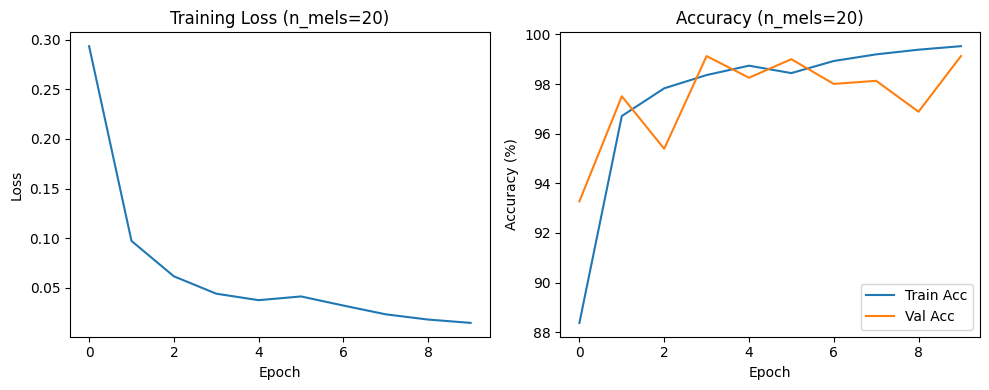


Running experiment with n_mels=40
Starting training with config: {'device': 'cuda', 'epochs': 10, 'batch_size': 128, 'lr': 0.001, 'num_workers': 4, 'use_wandb': False, 'project_name': 'speech-commands-experiments', 'n_mels': 40, 'experiment_name': 'n_mels_40'}
Epoch 1/10: Train Loss: 0.4004 | Train Acc: 84.27% | Val Acc: 94.77% | Time: 26.30s
Epoch 2/10: Train Loss: 0.1188 | Train Acc: 95.72% | Val Acc: 97.26% | Time: 22.85s
Epoch 3/10: Train Loss: 0.0832 | Train Acc: 97.14% | Val Acc: 96.26% | Time: 22.81s
Epoch 4/10: Train Loss: 0.0623 | Train Acc: 97.70% | Val Acc: 96.64% | Time: 22.52s
Epoch 5/10: Train Loss: 0.0564 | Train Acc: 97.85% | Val Acc: 97.51% | Time: 22.34s
Epoch 6/10: Train Loss: 0.0390 | Train Acc: 98.60% | Val Acc: 97.63% | Time: 22.69s
Epoch 7/10: Train Loss: 0.0313 | Train Acc: 98.82% | Val Acc: 97.88% | Time: 25.40s
Epoch 8/10: Train Loss: 0.0257 | Train Acc: 99.09% | Val Acc: 98.26% | Time: 23.43s
Epoch 9/10: Train Loss: 0.0385 | Train Acc: 98.71% | Val Acc: 98.1

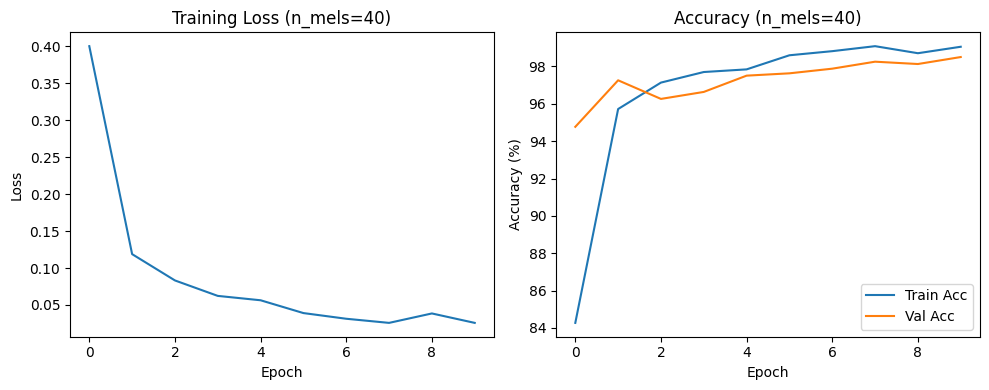


Running experiment with n_mels=80
Starting training with config: {'device': 'cuda', 'epochs': 10, 'batch_size': 128, 'lr': 0.001, 'num_workers': 4, 'use_wandb': False, 'project_name': 'speech-commands-experiments', 'n_mels': 80, 'experiment_name': 'n_mels_80'}
Epoch 1/10: Train Loss: 0.5330 | Train Acc: 83.12% | Val Acc: 95.52% | Time: 25.15s
Epoch 2/10: Train Loss: 0.1569 | Train Acc: 94.05% | Val Acc: 95.02% | Time: 25.22s
Epoch 3/10: Train Loss: 0.1043 | Train Acc: 96.29% | Val Acc: 96.64% | Time: 25.38s
Epoch 4/10: Train Loss: 0.0802 | Train Acc: 96.90% | Val Acc: 96.89% | Time: 25.27s
Epoch 5/10: Train Loss: 0.0660 | Train Acc: 97.74% | Val Acc: 97.26% | Time: 24.96s
Epoch 6/10: Train Loss: 0.0531 | Train Acc: 98.00% | Val Acc: 98.13% | Time: 25.17s
Epoch 7/10: Train Loss: 0.0465 | Train Acc: 98.38% | Val Acc: 97.38% | Time: 28.11s
Epoch 8/10: Train Loss: 0.0359 | Train Acc: 98.66% | Val Acc: 92.15% | Time: 25.15s
Epoch 9/10: Train Loss: 0.0455 | Train Acc: 98.35% | Val Acc: 97.6

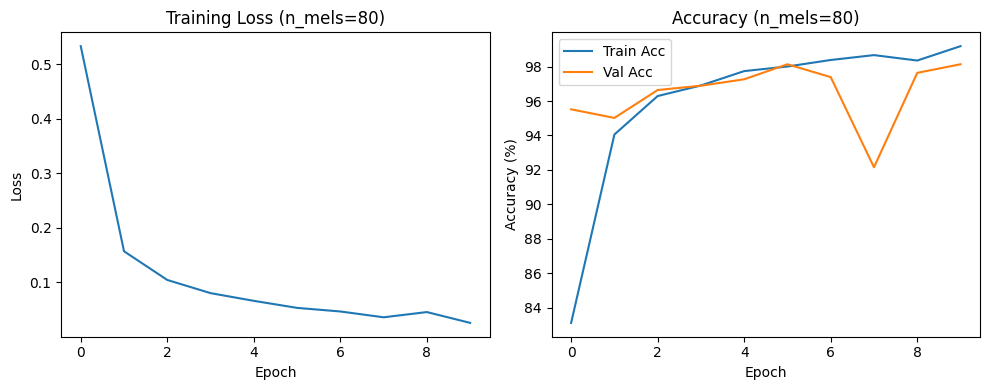

In [157]:
n_mels_list = [20, 40, 80]
n_mels_results = run_n_mels_experiment(n_mels_list, base_config)

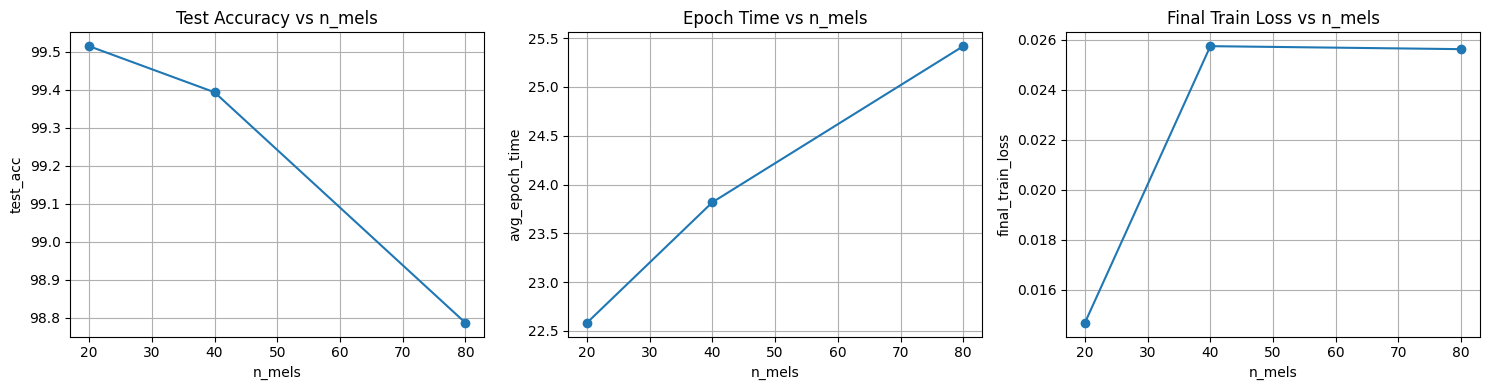

In [158]:
plot_comparison_results(
    n_mels_results,
    'n_mels',
    ['test_acc', 'avg_epoch_time', 'final_train_loss'],
    ['Test Accuracy vs n_mels', 'Epoch Time vs n_mels', 'Final Train Loss vs n_mels']
)

In [161]:
n_mels_results

,n_mels,test_acc,avg_epoch_time,best_val_acc,best_train_acc,final_train_loss
0,20,99.514563,22.583363,99.128269,99.528154,0.014689
1,40,99.393204,23.818317,98.505604,99.087763,0.025739
2,80,98.786408,25.417807,98.132005,99.182133,0.025620



Running experiment with groups=1
Starting training with config: {'device': 'cuda', 'epochs': 10, 'batch_size': 128, 'lr': 0.001, 'num_workers': 4, 'use_wandb': False, 'project_name': 'speech-commands-experiments', 'n_mels': 20, 'conv_groups': 1, 'experiment_name': 'groups_1'}
Epoch 1/10: Train Loss: 0.4863 | Train Acc: 79.22% | Val Acc: 96.14% | Time: 30.93s
Epoch 2/10: Train Loss: 0.1179 | Train Acc: 96.05% | Val Acc: 95.27% | Time: 23.87s
Epoch 3/10: Train Loss: 0.0819 | Train Acc: 97.17% | Val Acc: 97.76% | Time: 23.43s
Epoch 4/10: Train Loss: 0.0706 | Train Acc: 97.47% | Val Acc: 97.63% | Time: 24.25s
Epoch 5/10: Train Loss: 0.0534 | Train Acc: 98.14% | Val Acc: 91.28% | Time: 23.66s
Epoch 6/10: Train Loss: 0.0454 | Train Acc: 98.54% | Val Acc: 98.51% | Time: 23.78s
Epoch 7/10: Train Loss: 0.0341 | Train Acc: 98.76% | Val Acc: 98.01% | Time: 23.57s
Epoch 8/10: Train Loss: 0.0377 | Train Acc: 98.79% | Val Acc: 97.26% | Time: 24.70s
Epoch 9/10: Train Loss: 0.0320 | Train Acc: 99.04%

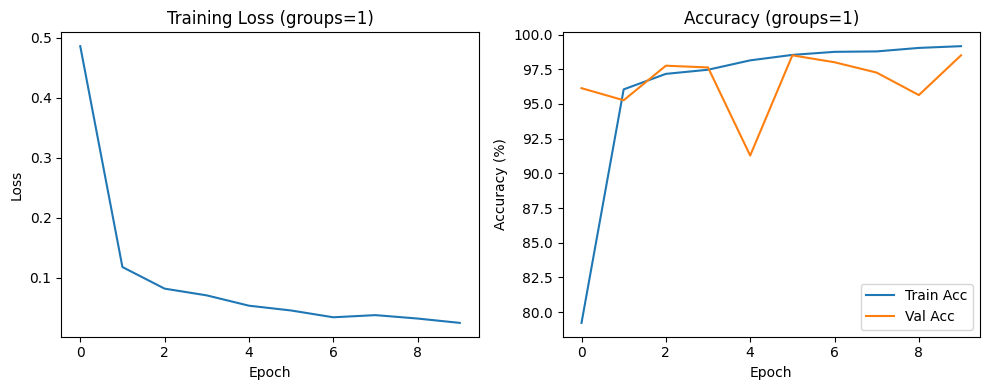


Running experiment with groups=2
Starting training with config: {'device': 'cuda', 'epochs': 10, 'batch_size': 128, 'lr': 0.001, 'num_workers': 4, 'use_wandb': False, 'project_name': 'speech-commands-experiments', 'n_mels': 20, 'conv_groups': 2, 'experiment_name': 'groups_2'}
Epoch 1/10: Train Loss: 0.3965 | Train Acc: 83.36% | Val Acc: 93.03% | Time: 24.33s
Epoch 2/10: Train Loss: 0.1161 | Train Acc: 95.94% | Val Acc: 96.26% | Time: 23.85s
Epoch 3/10: Train Loss: 0.0778 | Train Acc: 97.29% | Val Acc: 97.14% | Time: 24.44s
Epoch 4/10: Train Loss: 0.0637 | Train Acc: 97.80% | Val Acc: 97.26% | Time: 24.47s
Epoch 5/10: Train Loss: 0.0517 | Train Acc: 98.21% | Val Acc: 97.38% | Time: 24.36s
Epoch 6/10: Train Loss: 0.0370 | Train Acc: 98.74% | Val Acc: 98.01% | Time: 24.62s
Epoch 7/10: Train Loss: 0.0325 | Train Acc: 98.99% | Val Acc: 98.13% | Time: 24.07s
Epoch 8/10: Train Loss: 0.0233 | Train Acc: 99.26% | Val Acc: 98.13% | Time: 26.28s
Epoch 9/10: Train Loss: 0.0223 | Train Acc: 99.20%

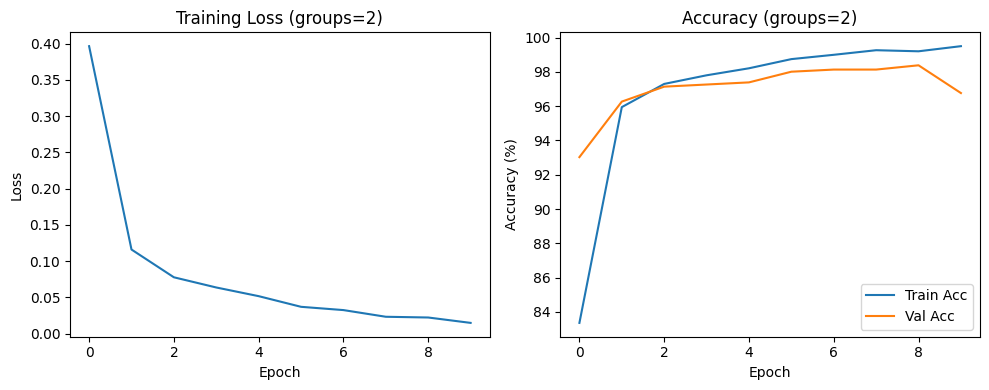


Running experiment with groups=4
Starting training with config: {'device': 'cuda', 'epochs': 10, 'batch_size': 128, 'lr': 0.001, 'num_workers': 4, 'use_wandb': False, 'project_name': 'speech-commands-experiments', 'n_mels': 20, 'conv_groups': 4, 'experiment_name': 'groups_4'}
Epoch 1/10: Train Loss: 0.3152 | Train Acc: 86.69% | Val Acc: 95.14% | Time: 24.99s
Epoch 2/10: Train Loss: 0.1128 | Train Acc: 96.04% | Val Acc: 96.89% | Time: 25.06s
Epoch 3/10: Train Loss: 0.0821 | Train Acc: 97.01% | Val Acc: 96.39% | Time: 24.42s
Epoch 4/10: Train Loss: 0.0540 | Train Acc: 98.10% | Val Acc: 97.51% | Time: 24.66s
Epoch 5/10: Train Loss: 0.0493 | Train Acc: 98.33% | Val Acc: 97.26% | Time: 24.43s
Epoch 6/10: Train Loss: 0.0424 | Train Acc: 98.46% | Val Acc: 96.89% | Time: 24.32s
Epoch 7/10: Train Loss: 0.0381 | Train Acc: 98.57% | Val Acc: 98.13% | Time: 24.27s
Epoch 8/10: Train Loss: 0.0276 | Train Acc: 98.76% | Val Acc: 98.26% | Time: 26.26s
Epoch 9/10: Train Loss: 0.0229 | Train Acc: 99.23%

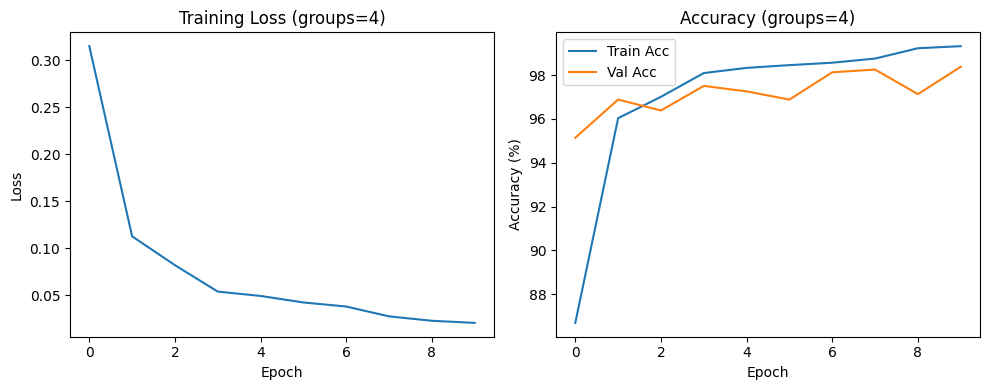


Running experiment with groups=8
Starting training with config: {'device': 'cuda', 'epochs': 10, 'batch_size': 128, 'lr': 0.001, 'num_workers': 4, 'use_wandb': False, 'project_name': 'speech-commands-experiments', 'n_mels': 20, 'conv_groups': 8, 'experiment_name': 'groups_8'}
Epoch 1/10: Train Loss: 0.5215 | Train Acc: 78.44% | Val Acc: 92.15% | Time: 31.60s
Epoch 2/10: Train Loss: 0.1627 | Train Acc: 94.51% | Val Acc: 96.01% | Time: 26.38s
Epoch 3/10: Train Loss: 0.1034 | Train Acc: 96.35% | Val Acc: 95.64% | Time: 24.29s
Epoch 4/10: Train Loss: 0.0831 | Train Acc: 96.98% | Val Acc: 95.14% | Time: 24.02s
Epoch 5/10: Train Loss: 0.0674 | Train Acc: 97.63% | Val Acc: 93.52% | Time: 23.38s
Epoch 6/10: Train Loss: 0.0485 | Train Acc: 98.21% | Val Acc: 97.26% | Time: 23.36s
Epoch 7/10: Train Loss: 0.0394 | Train Acc: 98.69% | Val Acc: 96.89% | Time: 24.11s
Epoch 8/10: Train Loss: 0.0368 | Train Acc: 98.80% | Val Acc: 96.51% | Time: 23.76s
Epoch 9/10: Train Loss: 0.0284 | Train Acc: 99.04%

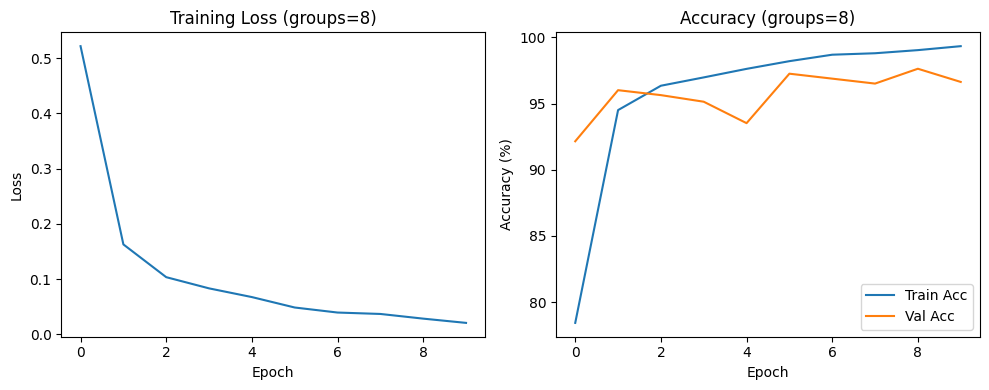

In [159]:
best_n_mels = n_mels_results.loc[n_mels_results['test_acc'].idxmax()]['n_mels']
base_config['n_mels'] = int(best_n_mels)

groups_list = [1, 2, 4, 8]
groups_results = run_groups_experiment(groups_list, base_config)

In [162]:
groups_results

,groups,test_acc,avg_epoch_time,best_val_acc,best_train_acc,final_train_loss,total_params,flops
0,1,99.150485,24.598954,98.505604,99.166405,0.024740,486722,973444
1,2,97.694175,24.939315,98.381071,99.496697,0.014881,440642,881284
2,4,98.422330,26.189857,98.381071,99.323687,0.020659,417602,835204
3,8,98.179612,24.781432,97.633873,99.339415,0.020660,406082,812164


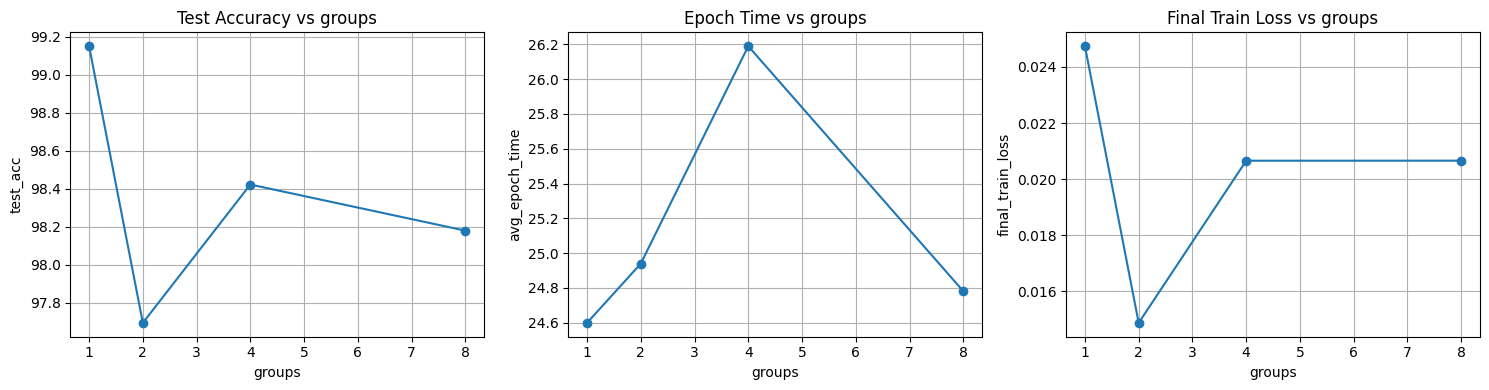

In [163]:
plot_comparison_results(
    groups_results,
    'groups',
    ['test_acc', 'avg_epoch_time', 'final_train_loss'],
    ['Test Accuracy vs groups', 'Epoch Time vs groups', 'Final Train Loss vs groups']
)